In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv('Basic_Stats.csv')
print(df.shape)
df['Tournament App?'] = df['School'].str.contains('NCAA', case=True)*1 # 1 if tournament appearance
df.head()

(9802, 33)


,School,Games Played,Wins,Losses,W-L%,Simple Rating System,Strength of Schedule,Conf. Wins,Conf. Losses,Home Wins,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Year,Tournament App?
0,Air Force,28,5,23,0.179,-5.62,5.05,1.0,17.0,5.0,...,0.628,NaN,1040.0,385.0,154.0,79.0,403.0,555.0,1996,0
1,Akron,26,3,23,0.115,-11.16,2.52,0.0,18.0,2.0,...,0.695,NaN,782.0,307.0,147.0,60.0,372.0,454.0,1996,0
2,Alabama,32,19,13,0.594,6.99,6.11,9.0,7.0,12.0,...,0.663,NaN,1252.0,408.0,197.0,196.0,440.0,567.0,1996,0
3,Alabama State,27,9,18,0.333,-23.42,-12.79,5.0,9.0,5.0,...,0.644,NaN,834.0,289.0,225.0,51.0,326.0,482.0,1996,0
4,Alcorn State,25,10,15,0.400,-18.20,-9.20,7.0,7.0,7.0,...,0.658,NaN,1009.0,354.0,233.0,90.0,472.0,558.0,1996,0


In [3]:
# Introduce per game stats
for per_game_col in df.columns[13:32]:
    if '%' in per_game_col:
        continue
    else:
        df[per_game_col+' Per Game'] = df[per_game_col]/df['Games Played']
df.head()

,School,Games Played,Wins,Losses,W-L%,Simple Rating System,Strength of Schedule,Conf. Wins,Conf. Losses,Home Wins,...,3PA Per Game,FTM Per Game,FTA Per Game,ORB Per Game,TRB Per Game,AST Per Game,STL Per Game,BLK Per Game,TOV Per Game,PF Per Game
0,Air Force,28,5,23,0.179,-5.62,5.05,1.0,17.0,5.0,...,14.785714,13.214286,21.035714,NaN,37.142857,13.750000,5.500000,2.821429,14.392857,19.821429
1,Akron,26,3,23,0.115,-11.16,2.52,0.0,18.0,2.0,...,13.884615,14.115385,20.307692,NaN,30.076923,11.807692,5.653846,2.307692,14.307692,17.461538
2,Alabama,32,19,13,0.594,6.99,6.11,9.0,7.0,12.0,...,21.875000,11.312500,17.062500,NaN,39.125000,12.750000,6.156250,6.125000,13.750000,17.718750
3,Alabama State,27,9,18,0.333,-23.42,-12.79,5.0,9.0,5.0,...,18.037037,14.481481,22.481481,NaN,30.888889,10.703704,8.333333,1.888889,12.074074,17.851852
4,Alcorn State,25,10,15,0.400,-18.20,-9.20,7.0,7.0,7.0,...,16.120000,15.160000,23.040000,NaN,40.360000,14.160000,9.320000,3.600000,18.880000,22.320000


In [4]:
# Let's focus the analysis to 2019-2010 to not have to bother with NaN entries for now
df = df[(df['Year'] >= 2010) & (df['Year'] <= 2019)]
df.columns

Index(['School', 'Games Played', 'Wins', 'Losses', 'W-L%',
       'Simple Rating System', 'Strength of Schedule', 'Conf. Wins',
       'Conf. Losses', 'Home Wins', 'Home Losses', 'Away Wins', 'Away Losses',
       'Total Pts Scored', 'Total Pts Suffered', 'Minutes Played', 'FGM',
       'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Year', 'Tournament App?',
       'Total Pts Scored Per Game', 'Total Pts Suffered Per Game',
       'Minutes Played Per Game', 'FGM Per Game', 'FGA Per Game',
       '3PM Per Game', '3PA Per Game', 'FTM Per Game', 'FTA Per Game',
       'ORB Per Game', 'TRB Per Game', 'AST Per Game', 'STL Per Game',
       'BLK Per Game', 'TOV Per Game', 'PF Per Game'],
      dtype='object')

In [5]:
# Make train and test sets
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df[['Minutes Played Per Game', 'FGM Per Game', 'FGA Per Game',
       '3PM Per Game', '3PA Per Game', 'FTM Per Game', 'FTA Per Game',
       'ORB Per Game', 'TRB Per Game', 'AST Per Game', 'STL Per Game',
       'BLK Per Game', 'TOV Per Game', 'PF Per Game']], df['Tournament App?'], test_size=0.2, random_state=40)

## Clustering

### k-NN with original data

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

For n_clusters = 2, the silhouette score is : 0.2
For n_clusters = 3, the silhouette score is : 0.18
For n_clusters = 4, the silhouette score is : 0.16
For n_clusters = 5, the silhouette score is : 0.14
For n_clusters = 6, the silhouette score is : 0.13
For n_clusters = 7, the silhouette score is : 0.13
For n_clusters = 8, the silhouette score is : 0.12
For n_clusters = 9, the silhouette score is : 0.11
For n_clusters = 10, the silhouette score is : 0.11
For n_clusters = 11, the silhouette score is : 0.11
For n_clusters = 12, the silhouette score is : 0.11
For n_clusters = 13, the silhouette score is : 0.11
For n_clusters = 14, the silhouette score is : 0.1
For n_clusters = 15, the silhouette score is : 0.1
For n_clusters = 16, the silhouette score is : 0.1
For n_clusters = 17, the silhouette score is : 0.11
For n_clusters = 18, the silhouette score is : 0.1
For n_clusters = 19, the silhouette score is : 0.1


Text(0, 0.5, 'silhouette score')

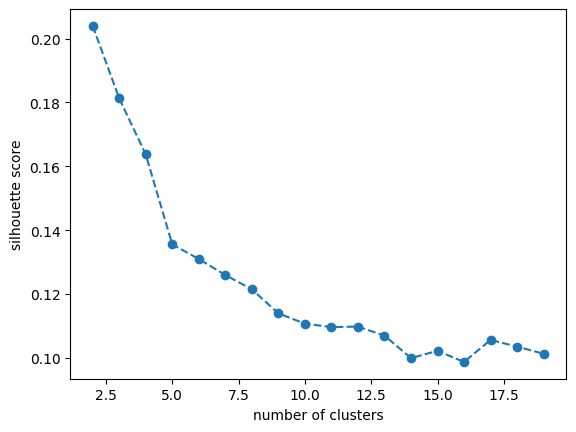

In [13]:
kmeans = KMeans(random_state=123, n_init="auto")

# Compute silhouette score for different number of clusters
scores = []
n_clusters = list(range(2,20))
for i in n_clusters:
  kmeans = KMeans(n_clusters = i).fit(X_train)
  labels = kmeans.labels_
  score = silhouette_score(X_train, labels, metric = 'euclidean')
  scores.append(score)
    
  print(f'For n_clusters = {i}, the silhouette score is : {round(score, 2)}')
    
plt.plot(range(2, 20), scores, marker = 'o', linestyle = '--')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

In [14]:
# Determine best number of clusters using grid search
param_grid = {
  'n_clusters': list(range(2,20))
}
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train)
grid_search.best_params_

{'n_clusters': 19}

### k-means with PCA data

Clustering with original data seems noisy. Instead, try with 3 PCA data.

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_train)

For n_clusters = 2, the silhouette score is : 0.28
For n_clusters = 3, the silhouette score is : 0.27
For n_clusters = 4, the silhouette score is : 0.26
For n_clusters = 5, the silhouette score is : 0.23
For n_clusters = 6, the silhouette score is : 0.23
For n_clusters = 7, the silhouette score is : 0.23
For n_clusters = 8, the silhouette score is : 0.23
For n_clusters = 9, the silhouette score is : 0.22
For n_clusters = 10, the silhouette score is : 0.22
For n_clusters = 11, the silhouette score is : 0.22
For n_clusters = 12, the silhouette score is : 0.22
For n_clusters = 13, the silhouette score is : 0.21
For n_clusters = 14, the silhouette score is : 0.22
For n_clusters = 15, the silhouette score is : 0.22
For n_clusters = 16, the silhouette score is : 0.22
For n_clusters = 17, the silhouette score is : 0.22
For n_clusters = 18, the silhouette score is : 0.21
For n_clusters = 19, the silhouette score is : 0.22


Text(0.5, 1.0, 'Silhouette score for different k in PCA')

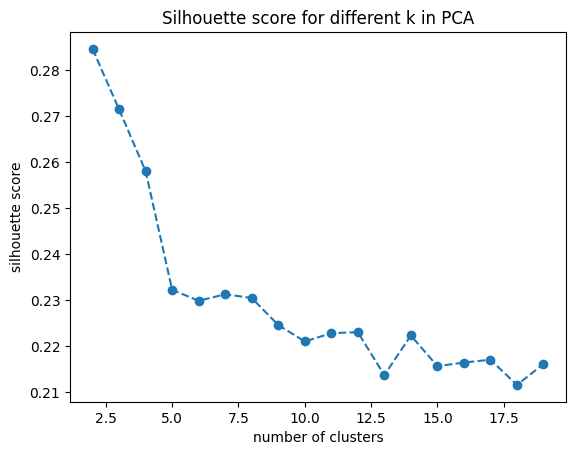

In [50]:
# Compute silhouette score for different number of clusters
scores = []
n_clusters = list(range(2,20))
for i in n_clusters:
  kmeans = KMeans(n_clusters = i).fit(X_reduced)
  labels = kmeans.labels_
  score = silhouette_score(X_reduced, labels, metric = 'euclidean')
  scores.append(score)
    
  print(f'For n_clusters = {i}, the silhouette score is : {round(score, 2)}')
    
plt.plot(range(2, 20), scores, marker = 'o', linestyle = '--')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette score for different k in PCA')

In [49]:
# Determine best number of clusters using grid search
param_grid = {
  'n_clusters': list(range(2,20))
}
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_reduced)
grid_search.best_params_

{'n_clusters': 19}

Clustering did not imporve much with PCA.

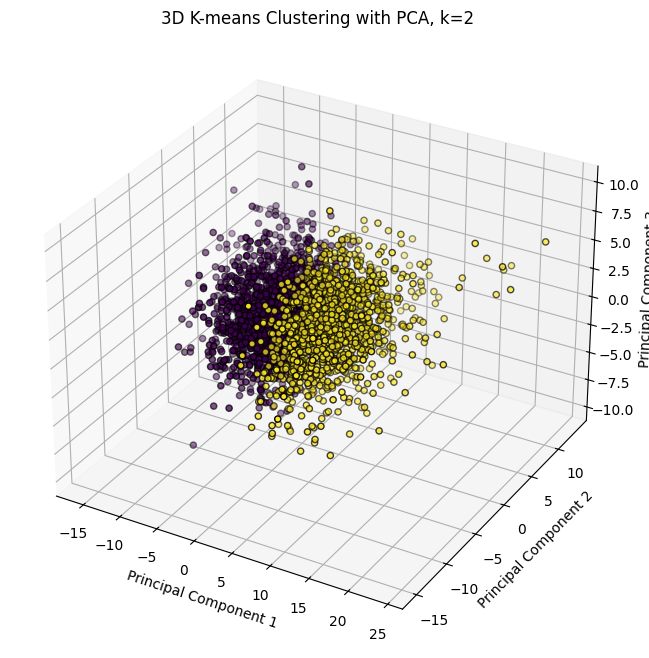

In [46]:
# Visualize k=2 clusters in 3 PCA field
kmeans_2 = KMeans(n_clusters=2).fit(X_reduced)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue' if label == True else 'green' for label in y_train]
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                     c=kmeans_2.labels_, cmap='viridis', marker='o', edgecolor='k')
ax.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], kmeans_2.cluster_centers_[:, 2], 
           s=300, c='red', marker='x')
ax.set_title('3D K-means Clustering with PCA, k=2')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

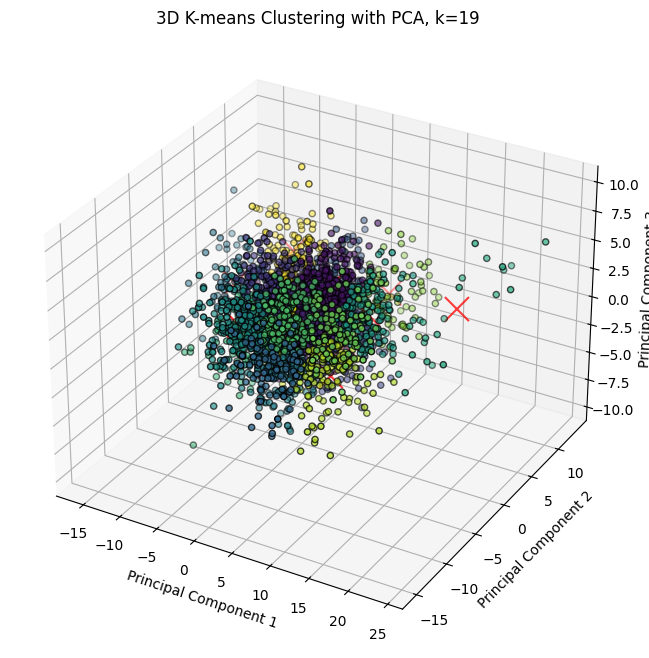

In [47]:
# Visualize k=19 clusters in 3 PCA field
kmeans_19 = KMeans(n_clusters=19).fit(X_reduced)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue' if label == True else 'green' for label in y_train]
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                     c=kmeans_19.labels_, cmap='viridis', marker='o', edgecolor='k')
ax.scatter(kmeans_19.cluster_centers_[:, 0], kmeans_19.cluster_centers_[:, 1], kmeans_19.cluster_centers_[:, 2], 
           s=300, c='red', marker='x')
ax.set_title('3D K-means Clustering with PCA, k=19')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

## Next possible steps
- Shape of clusters is not spherical. Try clustering with DBSCAN
- Perform feature reduction instead of PCA for more interpretable model